In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
import torch
from skimage.transform import resize
import random

In [2]:
## U-Net Definition
# https://github.com/milesial/Pytorch-UNet
import torch
import torch.nn as nn
import torch.nn.functional as F
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    img = torch.from_numpy(full_img)
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.shape[2], full_img.shape[1]), mode='bilinear')
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold

    return mask[0].long().squeeze().numpy()
import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm


def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)


def unique_mask_values(idx, mask_dir, mask_suffix):
    mask_file = list(mask_dir.glob(idx + mask_suffix + '.*'))[0]
    mask = np.asarray(load_image(mask_file))
    if mask.ndim == 2:
        return np.unique(mask)
    elif mask.ndim == 3:
        mask = mask.reshape(-1, mask.shape[-1])
        return np.unique(mask, axis=0)
    else:
        raise ValueError(f'Loaded masks should have 2 or 3 dimensions, found {mask.ndim}')


class BasicDataset(Dataset):
    def __init__(self, images_dir: str, mask_dir: str, scale: float = 1.0, mask_suffix: str = ''):
        self.images_dir = Path(images_dir)
        self.mask_dir = Path(mask_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if isfile(join(images_dir, file)) and not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')

        logging.info(f'Creating dataset with {len(self.ids)} examples')
        logging.info('Scanning mask files to determine unique values')
        with Pool() as p:
            unique = list(tqdm(
                p.imap(partial(unique_mask_values, mask_dir=self.mask_dir, mask_suffix=self.mask_suffix), self.ids),
                total=len(self.ids)
            ))

        self.mask_values = list(sorted(np.unique(np.concatenate(unique), axis=0).tolist()))
        logging.info(f'Unique mask values: {self.mask_values}')

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(mask_values, pil_img, scale, is_mask):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img = np.asarray(pil_img)

        if is_mask:
            mask = np.zeros((newH, newW), dtype=np.int64)
            for i, v in enumerate(mask_values):
                if img.ndim == 2:
                    mask[img == v] = i
                else:
                    mask[(img == v).all(-1)] = i

            return mask

        else:
            if img.ndim == 2:
                img = img[np.newaxis, ...]
            else:
                img = img.transpose((2, 0, 1))

            if (img > 1).any():
                img = img / 255.0

            return img

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.mask_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))

        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        mask = load_image(mask_file[0])
        img = load_image(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(self.mask_values, img, self.scale, is_mask=False)
        mask = self.preprocess(self.mask_values, mask, self.scale, is_mask=True)

        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous()
        }


class CarvanaDataset(BasicDataset):
    def __init__(self, images_dir, mask_dir, scale=1):
        super().__init__(images_dir, mask_dir, scale, mask_suffix='_mask')
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    #print(input.shape)
    #print(target.shape)
    assert input.size() == target.size()
    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

""" def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - dice_coeff(input, target, reduce_batch_first=True) """

def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.

    meow = nn.Sigmoid()
    # have to use contiguous since they may from a torch.view op
    iflat = meow(pred.contiguous().view(-1))
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat) 
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    # thanks to Greenstick on StackOverflow for the method 
   
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [3]:
model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(amsgrad=True,params=model.parameters(),lr=5e-5) # play around w/ this 
#optimizer = torch.optim.Adam(params=model.parameters()) # play around w/ this 
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)
gradient_clipping = 1.0

Using cache found in C:\Users\qtcc/.cache\torch\hub\milesial_Pytorch-UNet_master


In [4]:
images = np.load('gene_images.npy')
masks = np.load('mask_images.npy')
print(images.shape)
print(masks.shape)

(375, 500, 500)
(375, 500, 500, 1)


In [4]:
epochs = 5
data_length = 375
loss_storage_smart = []
loss_storage_stupid = []
images = np.load('gene_images.npy')
masks = np.load('mask_images.npy')
running_loss = 0
MODEL_PATH = 'unet_dice.pth'
#model.load_state_dict(torch.load(MODEL_PATH))
model.train()
for epoch in range(1, epochs + 1):
    for i in range(data_length):
        #print(i)
        printProgressBar(i+((epoch-1)*data_length),epochs*data_length)
        # make into torch tensors and do some manipulation
        sample_index = random.randint(0,data_length-1)
        image = images[sample_index]
        image = np.dstack((image, image, image)).T
        image = torch.from_numpy(image).unsqueeze(0)
        zero_mask = (masks[sample_index]<=0).T
        ones_mask = (masks[sample_index]>0).T
        true_mask = np.concatenate((zero_mask,ones_mask))
        #print(true_mask.shape)
        true_masks = torch.from_numpy(true_mask).unsqueeze(0)
        # main training 
        image = image.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device)
        with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=False):
            masks_pred = model(image)
            #print(masks_pred.shape)
            loss = criterion(masks_pred.squeeze(1), true_masks.float()) 
            #loss += dice_loss(masks_pred.squeeze(1), true_masks.float(), multiclass=False) 
            loss += dice_loss(masks_pred.squeeze(1), true_masks.float()) 

        optimizer.zero_grad(set_to_none=True)
        #grad_scaler.scale(loss).backward()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        running_loss += loss.item()
        if (i+((epoch-1)*data_length))%int(epochs*data_length/50)==0: # monitoring
            loss_storage_smart.append(running_loss/(epochs*data_length/50))
            running_loss = 0
        loss_storage_stupid.append(loss.item())


In [34]:
MODEL_PATH = 'unet_dice.pth'
torch.save(model.state_dict(), MODEL_PATH)

Text(0, 0.5, 'Logit BCE Loss')

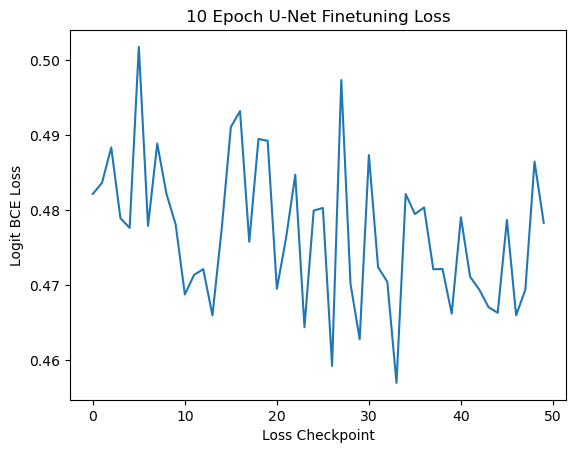

In [37]:
plt.plot((range(len(loss_storage_smart[1:]))),loss_storage_smart[1:])
plt.title('5 Epoch U-Net Finetuning Loss')
plt.xlabel('Loss Checkpoint')
plt.ylabel('Logit BCE Loss')

Text(0.5, 1.0, 'Logit BCE Loss')

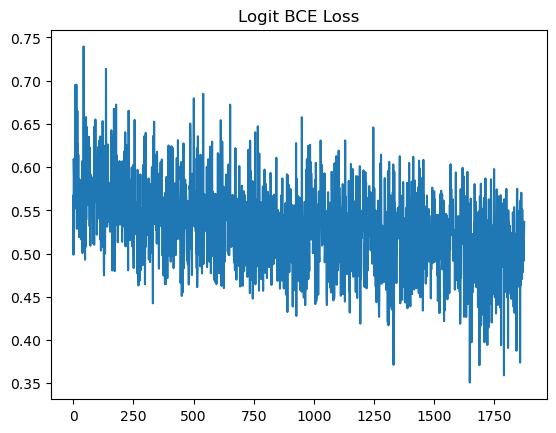

In [26]:
plt.plot((range(len(loss_storage_stupid))),loss_storage_stupid)
plt.title('Logit BCE Loss')

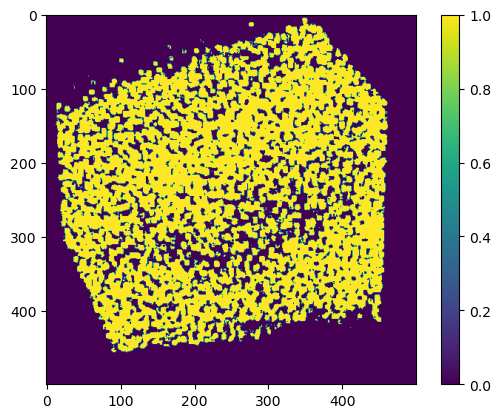

In [41]:
sample_index = 0


im = images[sample_index]
im = np.dstack((im, im, im)).T
im = torch.from_numpy(im).to(device,dtype=torch.float32).unsqueeze(0)
#out= predict_img(model,im,device,scale_factor=1,out_threshold=0.5)
out = model(im).cpu().detach().numpy()
out_final = (out[0][0]-out[0][1]<-1).T
plt.imshow(out_final)
#plt.imshow((out[0][1]).T)
plt.colorbar()

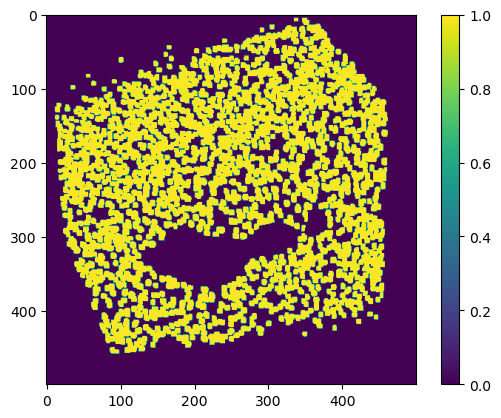

In [39]:
mask = masks[sample_index]
plt.imshow(mask>0)
plt.colorbar()

(500, 500)


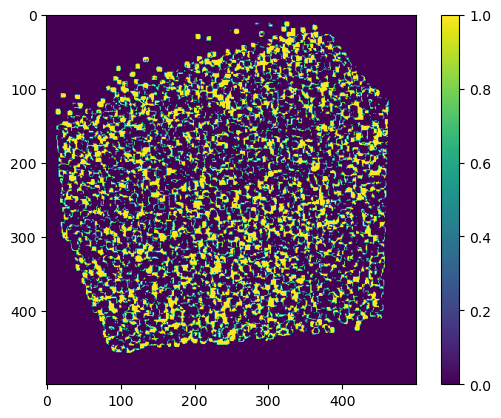

In [43]:
sample_index = 60

mask = masks[sample_index]>0
im = images[sample_index]
im = np.dstack((im, im, im)).T
im = torch.from_numpy(im).to(device,dtype=torch.float32).unsqueeze(0)
#out= predict_img(model,im,device,scale_factor=1,out_threshold=0.5)
out = model(im).cpu().detach().numpy()
out_final = (out[0][0]-out[0][1]<-1).T

mask = mask.squeeze(2)
print(out_final.shape)
plt.imshow((mask^out_final))
plt.colorbar()